# Import dependacy



In [3]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Books-Crossing Dataset
from http://www2.informatik.uni-freiburg.de/~cziegler/BX/


In [6]:
df = pd.read_csv('./Books Crossing Data/BX-Book-Ratings.csv', sep=';', encoding= 'unicode_escape')
print(df)

         User-ID         ISBN  Book-Rating
0         276725   034545104X            0
1         276726   0155061224            5
2         276727   0446520802            0
3         276729   052165615X            3
4         276729   0521795028            6
...          ...          ...          ...
1149775   276704   1563526298            9
1149776   276706   0679447156            0
1149777   276709   0515107662           10
1149778   276721   0590442449           10
1149779   276723  05162443314            8

[1149780 rows x 3 columns]


# userID and book ISBN

In [3]:
user_ids = df["User-ID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

book_ids = df["ISBN"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

df["user"] = df["User-ID"].map(user2user_encoded)
df["book"] = df["ISBN"].map(book2book_encoded)

print("==============="*3)
print("userID")
print("==============="*3)
print(df["user"])

print("\n"+"==============="*3)
print("Book ISBN")
print("==============="*3)
print(df["book"])

userID
0               0
1               1
2               2
3               3
4               3
            ...  
1149775    105278
1149776    105279
1149777    105280
1149778    105281
1149779    105282
Name: user, Length: 1149780, dtype: int64

Book ISBN
0               0
1               1
2               2
3               3
4               4
            ...  
1149775    226347
1149776      7295
1149777     12065
1149778     78598
1149779    340555
Name: book, Length: 1149780, dtype: int64


# Ratings, Number of User, Number of Book, Min and Max ratings

In [4]:
num_users = len(user2user_encoded)
num_books = len(book_encoded2book)
df["rating"] = df["Book-Rating"].values.astype(np.float32)

print("==============="*3)
print("Rating")
print("==============="*3)
print(df["rating"])

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print("\n"+"==============="*3)
print("Other information")
print("==============="*3)
print(
    "Number of users: {}, Number of Books: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_books, min_rating, max_rating
    )
)

Rating
0           0.0
1           5.0
2           0.0
3           3.0
4           6.0
           ... 
1149775     9.0
1149776     0.0
1149777    10.0
1149778    10.0
1149779     8.0
Name: rating, Length: 1149780, dtype: float32

Other information
Number of users: 105283, Number of Books: 340556, Min rating: 0.0, Max rating: 10.0


# Split training and validation datasets

In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "book"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Keras Model

In [6]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    
    # init
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)
    
    # call 
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        # Add all the components (including bias)
        x = dot_user_book + user_bias + book_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

#modeling
model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

C:\Users\hengw\Desktop\Temp\Mini Project 2\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train the model
Tune with batch size and epochs to optimize training time due to huge data and avoid over-fitting.<br>

At the same time, find best model traning configuration.

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=5000,
    epochs=2,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/2
207/207 [==============================] - 39s 183ms/step - loss: 0.6145 - val_loss: 0.5888
Epoch 2/2
207/207 [==============================] - 39s 190ms/step - loss: 0.5955 - val_loss: 0.6416


# Model Loss Plot
Model loss is improving at 0.59.<br>
Further train might cause over-fitting.

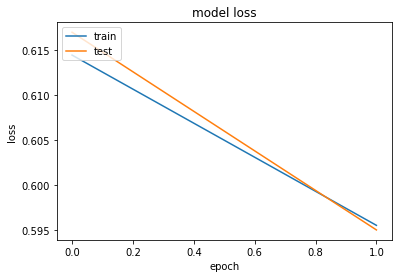

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Predict user top recommendations

In [46]:
book_df = pd.read_csv('./Books Crossing Data/BX-Books.csv', sep=';'
                      , error_bad_lines=False, encoding= 'unicode_escape')

# Let us get a user and see the top recommendations.
user_id = df['User-ID'].sample(1).iloc[0]

book_read_by_user = df[df['User-ID'] == user_id]

book_not_read = book_df[
    ~book_df["ISBN"].isin(book_read_by_user.ISBN.values)
]["ISBN"]
book_not_read = list(
    set(book_not_read).intersection(set(book2book_encoded.keys()))
)
book_not_read = [[book2book_encoded.get(x)] for x in book_not_read]

user_encoder = user2user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)
ratings = model.predict(user_book_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded2book.get(book_not_read[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("\n"+"====" * 9)
print("Books with high ratings from user")
print("----" * 8)
top_books_user = (
    book_read_by_user.sort_values(by="Book-Rating", ascending=False)
    .head(5)
    .ISBN.values
)
book_df_rows = book_df[book_df["ISBN"].isin(top_books_user)]
for row in book_df_rows.itertuples():
    print(row[2], ":", row[3])

print("\n"+"----" * 8)
print("Top 10 boos recommendations")
print("----" * 8)
recommended_books = book_df[book_df["ISBN"].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row[2], ":", row[3])

C:\Users\hengw\AppData\Local\Temp\ipykernel_1580\2991945508.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  book_df = pd.read_csv('C:\\Users\\hengw\\Desktop\\Temp\\Mini Project 2\\Books Crossing Data\\BX-Books.csv', sep=';'
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 9\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw

Showing recommendations for user: 45418

Books with high ratings from user
--------------------------------
Four Blind Mice : James Patterson
The Summons : John Grisham
The Ties That Bind : Jayne Ann Krentz
Dark Horse : TAMI HOAG
Don't Tell a Soul : S. K. McClafferty

--------------------------------
Top 10 boos recommendations
--------------------------------
The Five People You Meet in Heaven : Mitch Albom
The Lovely Bones: A Novel : Alice Sebold
The Da Vinci Code : Dan Brown
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) : J. K. Rowling
Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson : MITCH ALBOM
The Hobbit : The Enchanting Prelude to The Lord of the Rings : J.R.R. TOLKIEN
Harry Potter and the Prisoner of Azkaban (Book 3) : J. K. Rowling
Harry Potter and the Goblet of Fire (Book 4) : J. K. Rowling
Harry Potter and the Chamber of Secrets (Book 2) : J. K. Rowling
Harry Potter and the Order of the Phoenix (Book 5) : J. K. Rowling
